In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor, RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LassoLarsIC
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.svm import SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from scipy.stats import kurtosis, skew, boxcox
from regressors import stats
from numpy import mean
from numpy import std
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train_filled_na.csv')
test = pd.read_csv('test_filled_na.csv')
train.drop('Id', axis = 1, inplace=True)
test.drop('Id', axis = 1, inplace=True)

# Drop Columns

In [3]:
train = train.drop(['LandSlope','GarageQual','GarageCond','LowQualFinSF','ScreenPorch','BsmtCond'],axis=1)
train = train[train.columns.drop(list(train.filter(regex='BldgType')))]
train = train[train.columns.drop(list(train.filter(regex='Street')))]
train = train[train.columns.drop(list(train.filter(regex='Utilities')))]
train = train[train.columns.drop(list(train.filter(regex='RoofMatl')))]
train = train[train.columns.drop(list(train.filter(regex='Electrical')))]

In [4]:
test = test.drop(['LandSlope','GarageQual','GarageCond','LowQualFinSF','ScreenPorch','BsmtCond'],axis=1)
test = test[test.columns.drop(list(test.filter(regex='BldgType')))]
test = test[test.columns.drop(list(test.filter(regex='Street')))]
test = test[test.columns.drop(list(test.filter(regex='Utilities')))]
test = test[test.columns.drop(list(test.filter(regex='RoofMatl')))]
test = test[test.columns.drop(list(test.filter(regex='Electrical')))]

# Outlier Detection

In [5]:
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(train.loc[:, train.columns != 'SalePrice'])
X_Scaled = pd.DataFrame(X_Scaled, columns = train.columns[train.columns != 'SalePrice'])
y = train['SalePrice']

In [6]:
X_sm = sm.add_constant(X_Scaled)
model = sm.OLS(list(y),X_sm)
results = model.fit()

In [7]:
C, P = OLSInfluence(results).cooks_distance

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:713: RuntimeWarning: divide by zero encountered in true_divide
  cooks_d2 *= hii / (1 - hii)


<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance', ylabel='distance'>

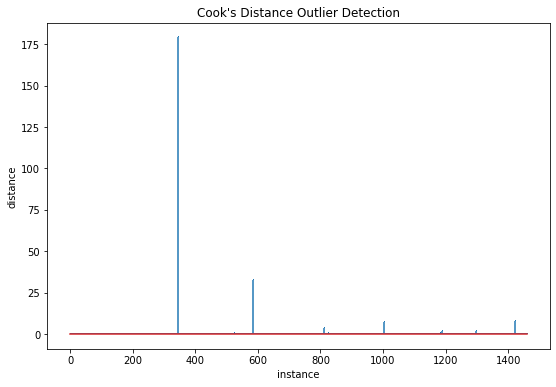

In [8]:
def plot_cooks_distance(c):
    _, ax = plt.subplots(figsize=(9,6))
    ax.stem(c, markerfmt=",")
    ax.set_xlabel("instance")
    ax.set_ylabel("distance")
    ax.set_title("Cook's Distance Outlier Detection")
    return ax


plot_cooks_distance(C)

In [76]:
#influential_points = C[C > 1]
#train.merge(pd.DataFrame(influential_points), left_index=True, right_index=True)
outliers = pd.DataFrame(C[C > 1])
outliers.columns = ["Cook's Distance"]
outliers

,Cook's Distance
346,179.030903
583,32.883227
810,3.843311
1003,7.048017
1187,1.623863
1298,2.036873
1370,inf
1423,7.962567


## Train w/ dummies

In [10]:
#data_mean, data_std = mean(train), std(train)

In [11]:
# cut_off = data_std * 3
# lower, upper = data_mean - cut_off, data_mean + cut_off

# outliers = {}
# for col in ['LotFrontage','LotArea','MasVnrArea','YearBuilt','YearRemodAdd','BsmtFinSF1','BsmtFinSF2',
#             'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF',
#            'OpenPorchSF','EnclosedPorch']:
#     #train[train['LotArea'].between(lower['LotArea'], upper['LotArea'], inclusive=False)]
#     m = train[col].between(lower[col], upper[col], inclusive=True)
#     outliers[col] = train[~m]
    
    

In [12]:
# outlier_indices = set()
# for col in outliers:
#     print(col, len(outliers[col]))
#     for idx in list(outliers[col].index):
#         #print(idx)
#         outlier_indices.add(idx)
        

In [13]:
train = train.drop(outliers.index, axis=0)

## Drop columns with all zeros

In [14]:
allZeroCols = train.columns[(train == 0).all()].to_list()
train = train.drop(allZeroCols, axis=1)

test = test.drop(allZeroCols, axis=1)

# Log Transformations

In [15]:
def logTransform(data, colsToTransform):
    for col in colsToTransform:
        data[col] = np.log1p(data[col])
        

In [16]:
colsToTransform = ['SalePrice']
logTransform(train, colsToTransform)

# Modeling

In [17]:
def getFeatureImportance(num, cols, features_importances_, sort):
    
    feature_importances = zip(cols, features_importances_)
    sorted_importance = sorted(list(feature_importances),key= lambda x: abs(x[1]),reverse=False if sort == 'ascending' else True)

    f, ax = plt.subplots(figsize=(13, 9))
    sns.barplot([x[0] for x in sorted_importance[:num]], [x[1] for x in sorted_importance[:num]])
    plt.xticks(rotation=90)
    
    return sorted_importance

## Ridge Regression

In [18]:
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(train.loc[:, train.columns != 'SalePrice'])
X_Scaled = pd.DataFrame(X_Scaled, columns = train.columns[train.columns != 'SalePrice'])
y = train['SalePrice']

In [19]:
model = Ridge()
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,50,75,100,200,300,400,500,1000,2000]}
gridRidge = GridSearchCV(model, param_grid=params, cv=5)
gridRidge.fit(X_Scaled, y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100,
                                   200, 300, 400, 500, 1000, 2000]})

In [20]:
gridRidge.cv_results_

{'mean_fit_time': array([0.10661259, 0.00622835, 0.00581317, 0.00584803, 0.00541902,
        0.00484958, 0.0053071 , 0.00530109, 0.00528879, 0.00526862,
        0.00733566, 0.00860419, 0.0084609 , 0.00785294, 0.00669308]),
 'std_fit_time': array([1.98502734e-01, 6.11116604e-04, 8.28958325e-05, 1.74837375e-04,
        1.79659561e-04, 4.18468378e-04, 1.26637626e-04, 1.86131514e-04,
        1.87115871e-04, 2.26090185e-04, 8.92630309e-04, 7.74051767e-04,
        2.59157578e-04, 8.66058717e-04, 6.22887424e-04]),
 'mean_score_time': array([0.00405321, 0.00329056, 0.00311308, 0.00310564, 0.00289063,
        0.00272226, 0.0028573 , 0.00278287, 0.00289254, 0.00298123,
        0.0039196 , 0.00436673, 0.00450883, 0.00393662, 0.00362597]),
 'std_score_time': array([1.98713360e-04, 3.53217189e-04, 9.86372441e-05, 1.83721279e-04,
        7.19786283e-05, 3.38016775e-04, 1.03697403e-04, 1.00035208e-04,
        1.87703118e-05, 2.02393272e-04, 4.36717033e-04, 2.09001627e-04,
        1.22996871e-04, 3.57

In [21]:
gridRidge.best_params_

{'alpha': 400}

In [22]:
gridRidge.best_score_

0.8915386320412907

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[('OverallCond', 0.03063846635786677),
 ('GrLivArea', 0.02858076373922631),
 ('TotalSF', 0.02627179545900309),
 ('TotalIndoorSF', 0.02592048760733671),
 ('GrLivAreaHighQualitySF', 0.023826517258220912),
 ('OverallQual', 0.023659164804911634),
 ('1stFlrSF', 0.02270259746046515),
 ('BsmtFinSF1', 0.02024817377483556),
 ('TotalBsmtSF', 0.019727905044106566),
 ('NeighborhoodDummy_NridgHt', 0.018791807987729454),
 ('KitchenQual', 0.018748275280426333),
 ('YearRemodAdd', 0.018510250642229147),
 ('YearBuilt', 0.01818235560308987),
 ('CentralAirDummy_Y', 0.01773872178576228),
 ('Condition2Dummy_PosN', -0.017190941118737996),
 ('BsmtQual', 0.01696666187346159),
 ('SaleConditionDummy_Normal', 0.01694122554119176),
 ('GarageArea', 0.016528871516654355),
 ('GarageCars', 0.016453726410615377),
 ('NeighborhoodDummy_MeadowV', -0.01619527199999032),
 ('NeighborhoodDummy_Crawfor', 0.016085462563285177),
 ('ExterQual', 0.015882789968536044),
 ('NeighborhoodDummy_StoneBr', 0.014945450042196442),
 ('MSSubC

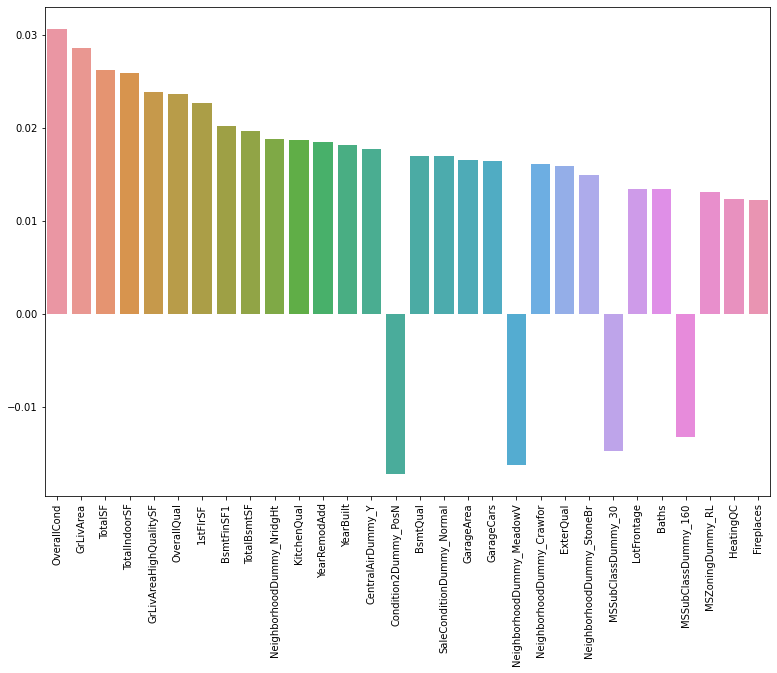

In [23]:
getFeatureImportance(30, X_Scaled.columns, gridRidge.best_estimator_.coef_,'descending')

In [24]:
gridRidge.score(X_Scaled, y)

0.9235057520618547

In [25]:
gridRidge.cv_results_

{'mean_fit_time': array([0.10661259, 0.00622835, 0.00581317, 0.00584803, 0.00541902,
        0.00484958, 0.0053071 , 0.00530109, 0.00528879, 0.00526862,
        0.00733566, 0.00860419, 0.0084609 , 0.00785294, 0.00669308]),
 'std_fit_time': array([1.98502734e-01, 6.11116604e-04, 8.28958325e-05, 1.74837375e-04,
        1.79659561e-04, 4.18468378e-04, 1.26637626e-04, 1.86131514e-04,
        1.87115871e-04, 2.26090185e-04, 8.92630309e-04, 7.74051767e-04,
        2.59157578e-04, 8.66058717e-04, 6.22887424e-04]),
 'mean_score_time': array([0.00405321, 0.00329056, 0.00311308, 0.00310564, 0.00289063,
        0.00272226, 0.0028573 , 0.00278287, 0.00289254, 0.00298123,
        0.0039196 , 0.00436673, 0.00450883, 0.00393662, 0.00362597]),
 'std_score_time': array([1.98713360e-04, 3.53217189e-04, 9.86372441e-05, 1.83721279e-04,
        7.19786283e-05, 3.38016775e-04, 1.03697403e-04, 1.00035208e-04,
        1.87703118e-05, 2.02393272e-04, 4.36717033e-04, 2.09001627e-04,
        1.22996871e-04, 3.57

## Lasso Regression

In [26]:
model = Lasso()
params = {'alpha':[0.0075,0.005,0.001,0.01,0.1,1,10,50,75,100,1000,2000],'max_iter':[1000]}
gridLasso = GridSearchCV(model, param_grid=params, cv=5)
gridLasso.fit(X_Scaled, y)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0075, 0.005, 0.001, 0.01, 0.1, 1, 10, 50,
                                   75, 100, 1000, 2000],
                         'max_iter': [1000]})

In [27]:
gridLasso.cv_results_

{'mean_fit_time': array([0.01913724, 0.02107286, 0.06764722, 0.0142983 , 0.00699363,
        0.00458703, 0.00433164, 0.00454702, 0.00457916, 0.00461864,
        0.00441175, 0.00467482]),
 'std_fit_time': array([3.92607274e-03, 4.51314253e-03, 1.44241323e-02, 1.51245909e-03,
        2.91677341e-04, 2.50202305e-04, 5.19350237e-04, 1.53379888e-04,
        1.15247171e-04, 1.27010391e-04, 2.72551435e-04, 3.47187227e-05]),
 'mean_score_time': array([0.00333481, 0.00280991, 0.003404  , 0.00287747, 0.00269227,
        0.00274467, 0.00247855, 0.00261407, 0.00275321, 0.00270343,
        0.00251455, 0.00264382]),
 'std_score_time': array([4.30890578e-04, 1.11005867e-04, 1.92184932e-04, 1.12235556e-04,
        1.46135801e-04, 2.63292406e-04, 3.99827642e-04, 2.20308799e-04,
        7.32519347e-05, 8.37910216e-05, 3.83838286e-04, 3.24630898e-04]),
 'param_alpha': masked_array(data=[0.0075, 0.005, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100,
                    1000, 2000],
              mask=[False, False,

In [28]:
gridLasso.best_params_

{'alpha': 0.005, 'max_iter': 1000}

In [29]:
gridLasso.best_score_

0.8932331799048507

In [30]:
gridLasso.cv_results_

{'mean_fit_time': array([0.01913724, 0.02107286, 0.06764722, 0.0142983 , 0.00699363,
        0.00458703, 0.00433164, 0.00454702, 0.00457916, 0.00461864,
        0.00441175, 0.00467482]),
 'std_fit_time': array([3.92607274e-03, 4.51314253e-03, 1.44241323e-02, 1.51245909e-03,
        2.91677341e-04, 2.50202305e-04, 5.19350237e-04, 1.53379888e-04,
        1.15247171e-04, 1.27010391e-04, 2.72551435e-04, 3.47187227e-05]),
 'mean_score_time': array([0.00333481, 0.00280991, 0.003404  , 0.00287747, 0.00269227,
        0.00274467, 0.00247855, 0.00261407, 0.00275321, 0.00270343,
        0.00251455, 0.00264382]),
 'std_score_time': array([4.30890578e-04, 1.11005867e-04, 1.92184932e-04, 1.12235556e-04,
        1.46135801e-04, 2.63292406e-04, 3.99827642e-04, 2.20308799e-04,
        7.32519347e-05, 8.37910216e-05, 3.83838286e-04, 3.24630898e-04]),
 'param_alpha': masked_array(data=[0.0075, 0.005, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100,
                    1000, 2000],
              mask=[False, False,

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[('TotalSF', 0.10454574348678136),
 ('GrLivArea', 0.08205651300724448),
 ('YearBuilt', 0.04710619167814262),
 ('OverallCond', 0.039731911510278065),
 ('BsmtFinSF1', 0.03108324851442173),
 ('OverallQual', 0.029861151373275975),
 ('GarageCars', 0.02287463160279811),
 ('SaleTypeDummy_New', 0.022298542812006838),
 ('Condition2Dummy_PosN', -0.020718029668256668),
 ('ExterQual', 0.020021317179144085),
 ('KitchenQual', 0.018952315356775544),
 ('NeighborhoodDummy_NridgHt', 0.017883353405243385),
 ('NeighborhoodDummy_Crawfor', 0.017586456102231626),
 ('SaleConditionDummy_Normal', 0.015599910037727671),
 ('FoundationDummy_PConc', 0.0144412083094791),
 ('Fireplaces', 0.013875822201106681),
 ('CentralAirDummy_Y', 0.013849916287977507),
 ('YearRemodAdd', 0.013736098790191217),
 ('MSZoningDummy_RL', 0.01331378028758907),
 ('LotArea', 0.01272063666680883),
 ('NeighborhoodDummy_MeadowV', -0.012716656839955466),
 ('FunctionalDummy_Typ', 0.012430518720595078),
 ('NeighborhoodDummy_StoneBr', 0.0123906424

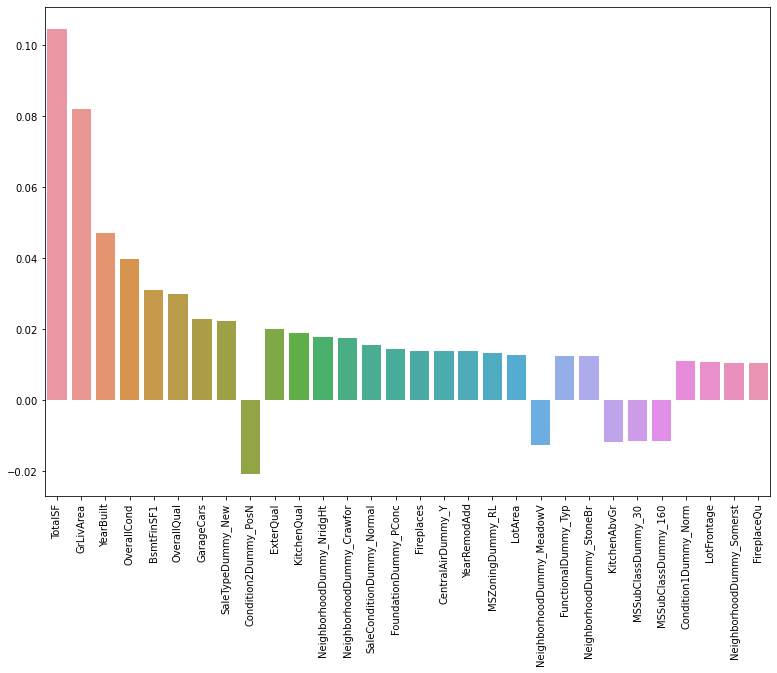

In [31]:
getFeatureImportance(30, X_Scaled.columns, gridLasso.best_estimator_.coef_, '')

In [32]:
gridLasso.score(X_Scaled, y)

0.9171132108263732

## Linear Regression on Lasso Selected Features

In [33]:
lasso_coef_estimates = list(zip(X_Scaled.columns,gridLasso.best_estimator_.coef_))
lasso_coef_non_zero = [var[0] for var in lasso_coef_estimates if var[1] != 0]

In [34]:
X_sm = X_Scaled[lasso_coef_non_zero]
X_sm = sm.add_constant(X_sm)
model = sm.OLS(list(y),X_sm)
results = model.fit()

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     237.2
Date:                Sat, 31 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:32:20   Log-Likelihood:                 1135.8
No. Observations:                1452   AIC:                            -2130.
Df Residuals:                    1381   BIC:                            -1755.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        12.0234      0.003   4037.120      0.000      12.018      12.029
LotFrontage                   0.0146      0.004      3.541      0.000       0.007       0.023
LotArea                       0.0125      0.004      3.462      0.001       0.005       0.020
OverallQual                   0.0247      0.004      5.667      0.000       0.016       0.033
OverallCond                   0.0444      0.004     10.825      0.000       0.036       0.052
YearBuilt                     0.0529      0.008      6.281      0.000       0.036       0.069
YearRemodAdd                  0.0112      0.005      2.212      0.027       0.001       0.021
MasVnrArea                    0.0087      0.004      2.309      0.021       0.001       0.016
ExterQual                     0.0149      0.005      2.784      0.005       0.004       0.025
BsmtQual                      0.0106      0.005      2.066      0.039       0.001       0.021
BsmtExposure                 -0.0077      0.004     -2.191      0.029      -0.015      -0.001
BsmtFinSF1                    0.0333      0.005      6.923      0.000       0.024       0.043
BsmtFinSF2                    0.0063      0.003      1.850      0.065      -0.000       0.013
HeatingQC                     0.0101      0.004      2.483      0.013       0.002       0.018
1stFlrSF                      0.0133      0.007      1.943      0.052      -0.000       0.027
GrLivArea                     0.0892      0.009      9.655      0.000       0.071       0.107
BsmtFullBath                  0.0118      0.004      2.722      0.007       0.003       0.020
HalfBath                      0.0078      0.004      1.841      0.066      -0.001       0.016
KitchenAbvGr                 -0.0136      0.004     -3.704      0.000      -0.021      -0.006
KitchenQual                   0.0153      0.005      3.092      0.002       0.006       0.025
Fireplaces                    0.0142      0.007      2.164      0.031       0.001       0.027
FireplaceQu                   0.0066      0.007      0.988      0.323      -0.007       0.020
GarageYrBlt                   0.0048      0.005      1.063      0.288      -0.004       0.014
GarageFinish                 -0.0052      0.004     -1.303      0.193      -0.013       0.003
GarageCars                    0.0212      0.006      3.697      0.000       0.010       0.033
WoodDeckSF                    0.0088      0.003      2.627      0.009       0.002       0.015
MoSold                        0.0054      0.003      1.758      0.079      -0.001       0.011
TotalSF                       0.0794      0.012      6.689      0.000       0.056       0.103
Baths                         0.0116      0.006      1.899      0.058      -0.000       0.024
MSSubClassDummy_30           -0.0147      0.004     -4.049      0.000      

### Refit until all vars significant

In [36]:
while True:
    if len(results.pvalues[results.pvalues > 0.05]) == 0:
        break
    significant_coefs = results.pvalues[results.pvalues < 0.05]
    significant_coefs = significant_coefs[significant_coefs.index != 'const']

    X_sm = X_Scaled[significant_coefs.index]
    X_sm = sm.add_constant(X_sm)
    model = sm.OLS(list(y),X_sm)
    results = model.fit()

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     364.3
Date:                Sat, 31 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:32:20   Log-Likelihood:                 1099.8
No. Observations:                1452   AIC:                            -2110.
Df Residuals:                    1407   BIC:                            -1872.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        12.0234      0.003   3975.264      0.000      12.018      12.029
LotFrontage                   0.0139      0.004      3.397      0.001       0.006       0.022
LotArea                       0.0132      0.004      3.719      0.000       0.006       0.020
OverallQual                   0.0276      0.004      6.428      0.000       0.019       0.036
OverallCond                   0.0417      0.004     10.421      0.000       0.034       0.050
YearBuilt                     0.0641      0.007      9.820      0.000       0.051       0.077
YearRemodAdd                  0.0148      0.005      2.987      0.003       0.005       0.025
MasVnrArea                    0.0081      0.004      2.198      0.028       0.001       0.015
ExterQual                     0.0203      0.005      3.841      0.000       0.010       0.031
BsmtQual                      0.0132      0.005      2.720      0.007       0.004       0.023
BsmtExposure                 -0.0069      0.004     -1.964      0.050      -0.014    -9.2e-06
BsmtFinSF1                    0.0311      0.005      6.833      0.000       0.022       0.040
HeatingQC                     0.0125      0.004      3.139      0.002       0.005       0.020
GrLivArea                     0.1099      0.007     15.804      0.000       0.096       0.124
BsmtFullBath                  0.0130      0.004      3.109      0.002       0.005       0.021
KitchenAbvGr                 -0.0165      0.003     -4.740      0.000      -0.023      -0.010
KitchenQual                   0.0162      0.005      3.250      0.001       0.006       0.026
Fireplaces                    0.0203      0.004      5.385      0.000       0.013       0.028
GarageCars                    0.0256      0.005      5.425      0.000       0.016       0.035
WoodDeckSF                    0.0111      0.003      3.317      0.001       0.005       0.018
TotalSF                       0.0816      0.009      9.277      0.000       0.064       0.099
MSSubClassDummy_30           -0.0130      0.004     -3.701      0.000      -0.020      -0.006
MSSubClassDummy_160          -0.0173      0.004     -4.611      0.000      -0.025      -0.010
MSZoningDummy_RL              0.0155      0.004      3.584      0.000       0.007       0.024
LotConfigDummy_CulDSac        0.0102      0.003      3.132      0.002       0.004       0.017
NeighborhoodDummy_BrkSide     0.0120      0.003      3.631      0.000       0.006       0.019
NeighborhoodDummy_ClearCr     0.0072      0.003      2.231      0.026       0.001       0.014
NeighborhoodDummy_Crawfor     0.0244      0.003      7.387      0.000       0.018       0.031
NeighborhoodDummy_Edwards    -0.0078      0.003     -2.359      0.018      -0.014      -0.001
NeighborhoodDummy_IDOTRR     -0.0106      0.003     -3.068      0.002      

#### Get CV results of model

In [38]:
model = LinearRegression()
params = {}
gridLr = GridSearchCV(model, param_grid=params, cv=5)
gridLr.fit(X_Scaled[significant_coefs.index], y)

GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={})

In [39]:
gridLr.cv_results_

{'mean_fit_time': array([0.00648174]),
 'std_fit_time': array([0.0048893]),
 'mean_score_time': array([0.00221381]),
 'std_score_time': array([0.00016405]),
 'params': [{}],
 'split0_test_score': array([0.91436558]),
 'split1_test_score': array([0.86837395]),
 'split2_test_score': array([0.85955513]),
 'split3_test_score': array([0.91289251]),
 'split4_test_score': array([0.91476292]),
 'mean_test_score': array([0.89399002]),
 'std_test_score': array([0.02468168]),
 'rank_test_score': array([1], dtype=int32)}

In [40]:
gridLr.score(X_Scaled[significant_coefs.index], y)

0.9193141462987087

## LassoLarsIC

In [41]:
model = LassoLarsIC()
params = {'criterion':['aic','bic']}
gridLL = GridSearchCV(model, param_grid=params, cv=5)
gridLL.fit(X_Scaled, y)

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 109 iterations, i.e. alpha=7.452e-05, with an active set of 99 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 161 iterations, i.e. alpha=3.411e-05, with an active set of 141 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate.

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 93 iterations, i.e. alpha=1.070e-04, with an active set of 85 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 94 iterations, i.e. alpha=1.064e-04, with an active set of 86 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the re

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 140 iterations, i.e. alpha=4.058e-05, with an active set of 128 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 141 iterations, i.e. alpha=4.033e-05, with an active set of 129 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate

GridSearchCV(cv=5, estimator=LassoLarsIC(),
             param_grid={'criterion': ['aic', 'bic']})

In [42]:
ll_non_zero_coefs = list(zip(X_Scaled.columns,gridLL.best_estimator_.coef_))
ll_non_zero_coefs = [col[0] for col in ll_non_zero_coefs if col[1] != 0]

In [43]:
X_sm = X_Scaled[ll_non_zero_coefs]
X_sm = sm.add_constant(X_sm)
model = sm.OLS(list(y),X_sm)
results = model.fit()

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     387.7
Date:                Sat, 31 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:32:21   Log-Likelihood:                 1022.7
No. Observations:                1452   AIC:                            -1969.
Df Residuals:                    1414   BIC:                            -1769.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        12.0234      0.003   3779.164      0.000      12.017      12.030
LotFrontage                   0.0096      0.004      2.279      0.023       0.001       0.018
LotArea                       0.0200      0.004      5.594      0.000       0.013       0.027
OverallQual                   0.0258      0.005      5.644      0.000       0.017       0.035
OverallCond                   0.0494      0.004     11.612      0.000       0.041       0.058
YearBuilt                     0.0578      0.007      7.873      0.000       0.043       0.072
YearRemodAdd                  0.0102      0.005      1.955      0.051   -3.48e-05       0.020
ExterQual                     0.0209      0.006      3.762      0.000       0.010       0.032
BsmtQual                      0.0062      0.005      1.211      0.226      -0.004       0.016
BsmtExposure                 -0.0085      0.004     -2.314      0.021      -0.016      -0.001
BsmtFinSF1                    0.0407      0.004     10.317      0.000       0.033       0.048
HeatingQC                     0.0132      0.004      3.106      0.002       0.005       0.022
GrLivArea                     0.0905      0.009     10.053      0.000       0.073       0.108
KitchenAbvGr                 -0.0187      0.004     -5.068      0.000      -0.026      -0.011
KitchenQual                   0.0155      0.005      2.979      0.003       0.005       0.026
Fireplaces                    0.0144      0.007      2.091      0.037       0.001       0.028
FireplaceQu                   0.0125      0.007      1.770      0.077      -0.001       0.026
GarageCars                    0.0242      0.005      4.868      0.000       0.014       0.034
WoodDeckSF                    0.0102      0.004      2.913      0.004       0.003       0.017
TotalSF                       0.0971      0.009     10.291      0.000       0.079       0.116
Baths                         0.0123      0.006      2.032      0.042       0.000       0.024
MSSubClassDummy_30           -0.0148      0.004     -4.056      0.000      -0.022      -0.008
MSSubClassDummy_160          -0.0133      0.004     -3.376      0.001      -0.021      -0.006
MSZoningDummy_RL             -0.0020      0.006     -0.327      0.744      -0.014       0.010
MSZoningDummy_RM             -0.0114      0.006     -1.907      0.057      -0.023       0.000
NeighborhoodDummy_Crawfor     0.0223      0.003      6.447      0.000       0.016       0.029
NeighborhoodDummy_Edwards    -0.0103      0.003     -3.011      0.003      -0.017      -0.004
NeighborhoodDummy_IDOTRR     -0.0149      0.004     -4.220      0.000      -0.022      -0.008
NeighborhoodDummy_MeadowV    -0.0179      0.004     -5.081      0.000      -0.025      -0.011
NeighborhoodDummy_NridgHt     0.0200      0.004      5.360      0.000      

### Refit until all vars significant

In [45]:
while True:
    if len(results.pvalues[results.pvalues > 0.05]) == 0:
        break
    significant_coefs = results.pvalues[results.pvalues < 0.05]
    significant_coefs = significant_coefs[significant_coefs.index != 'const']

    X_sm = X_Scaled[significant_coefs.index]
    X_sm = sm.add_constant(X_sm)
    model = sm.OLS(list(y),X_sm)
    results = model.fit()

In [46]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     459.2
Date:                Sat, 31 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:32:21   Log-Likelihood:                 1014.8
No. Observations:                1452   AIC:                            -1966.
Df Residuals:                    1420   BIC:                            -1797.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        12.0234      0.003   3766.503      0.000      12.017      12.030
LotFrontage                   0.0116      0.004      2.843      0.005       0.004       0.020
LotArea                       0.0199      0.004      5.572      0.000       0.013       0.027
OverallQual                   0.0275      0.005      6.093      0.000       0.019       0.036
OverallCond                   0.0516      0.004     12.999      0.000       0.044       0.059
YearBuilt                     0.0680      0.007     10.095      0.000       0.055       0.081
ExterQual                     0.0221      0.006      3.973      0.000       0.011       0.033
BsmtExposure                 -0.0089      0.004     -2.453      0.014      -0.016      -0.002
BsmtFinSF1                    0.0407      0.004     10.447      0.000       0.033       0.048
HeatingQC                     0.0146      0.004      3.488      0.001       0.006       0.023
GrLivArea                     0.0868      0.009      9.938      0.000       0.070       0.104
KitchenAbvGr                 -0.0208      0.004     -5.837      0.000      -0.028      -0.014
KitchenQual                   0.0178      0.005      3.502      0.000       0.008       0.028
Fireplaces                    0.0243      0.004      6.192      0.000       0.017       0.032
GarageCars                    0.0226      0.005      4.602      0.000       0.013       0.032
WoodDeckSF                    0.0116      0.003      3.312      0.001       0.005       0.018
TotalSF                       0.1022      0.009     11.493      0.000       0.085       0.120
Baths                         0.0154      0.006      2.569      0.010       0.004       0.027
MSSubClassDummy_30           -0.0150      0.004     -4.144      0.000      -0.022      -0.008
MSSubClassDummy_160          -0.0152      0.004     -4.039      0.000      -0.023      -0.008
NeighborhoodDummy_Crawfor     0.0237      0.003      6.928      0.000       0.017       0.030
NeighborhoodDummy_Edwards    -0.0100      0.003     -2.978      0.003      -0.017      -0.003
NeighborhoodDummy_IDOTRR     -0.0165      0.003     -4.840      0.000      -0.023      -0.010
NeighborhoodDummy_MeadowV    -0.0192      0.003     -5.658      0.000      -0.026      -0.013
NeighborhoodDummy_NridgHt     0.0205      0.004      5.634      0.000       0.013       0.028
NeighborhoodDummy_StoneBr     0.0175      0.003      5.224      0.000       0.011       0.024
Condition1Dummy_Norm          0.0145      0.003      4.319      0.000       0.008       0.021
Condition2Dummy_PosN         -0.0280      0.003     -8.188      0.000      -0.035      -0.021
FoundationDummy_PConc         0.0207      0.005      4.103      0.000       0.011       0.031
CentralAirDummy_Y             0.0150      0.004      3.903      0.000      

Text(0, 0.5, 'Residuals')

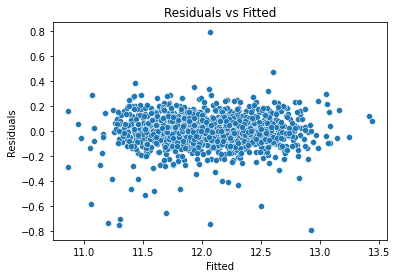

In [47]:
residuals = results.resid
fitted = results.fittedvalues
sns.scatterplot(x=fitted,y=residuals).set_title('Residuals vs Fitted')
plt.xlabel('Fitted')
plt.ylabel('Residuals')

#### Get CV results of model

In [48]:
model = LinearRegression()
params = {}
gridLr = GridSearchCV(model, param_grid=params, cv=5)
gridLr.fit(X_Scaled[significant_coefs.index], y)

GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={})

In [49]:
gridLr.cv_results_

{'mean_fit_time': array([0.00332699]),
 'std_fit_time': array([0.00049239]),
 'mean_score_time': array([0.00181589]),
 'std_score_time': array([0.00017631]),
 'params': [{}],
 'split0_test_score': array([0.9038674]),
 'split1_test_score': array([0.86060984]),
 'split2_test_score': array([0.85052776]),
 'split3_test_score': array([0.91660451]),
 'split4_test_score': array([0.91616384]),
 'mean_test_score': array([0.88955467]),
 'std_test_score': array([0.02830371]),
 'rank_test_score': array([1], dtype=int32)}

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[('TotalSF', 0.10223500111508835),
 ('GrLivArea', 0.08684007788333786),
 ('YearBuilt', 0.06796904201785774),
 ('OverallCond', 0.051587438992073326),
 ('BsmtFinSF1', 0.0407314111683659),
 ('Condition2Dummy_PosN', -0.027988934464284337),
 ('OverallQual', 0.027461493030254032),
 ('Fireplaces', 0.024329173239179186),
 ('NeighborhoodDummy_Crawfor', 0.023706820518838947),
 ('GarageCars', 0.022584210907717815),
 ('ExterQual', 0.02207576618806382),
 ('KitchenAbvGr', -0.02081769841274252),
 ('FoundationDummy_PConc', 0.02067676517734567),
 ('NeighborhoodDummy_NridgHt', 0.020528140069327273),
 ('LotArea', 0.019866172854034764),
 ('NeighborhoodDummy_MeadowV', -0.019236093915812894),
 ('SaleTypeDummy_New', 0.01846011609052975),
 ('FunctionalDummy_Typ', 0.017807623225112656),
 ('KitchenQual', 0.017756931567227213),
 ('NeighborhoodDummy_StoneBr', 0.0175120152424377),
 ('NeighborhoodDummy_IDOTRR', -0.016535792697818116),
 ('Baths', 0.01540640756410187),
 ('MSSubClassDummy_160', -0.015173234839854614),

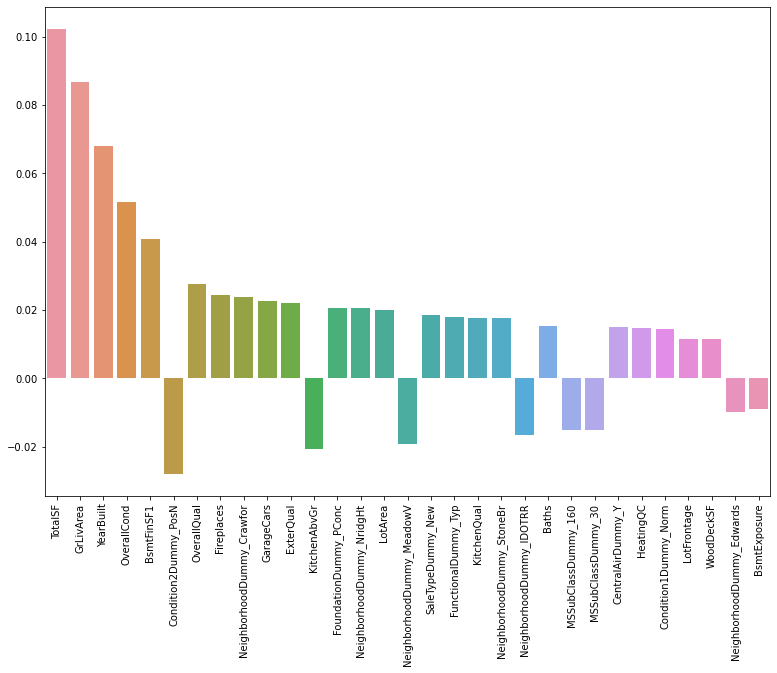

In [50]:
getFeatureImportance(50, X_Scaled[significant_coefs.index].columns, gridLr.best_estimator_.coef_,'descending')

In [80]:
estimates = pd.concat([pd.Series(X_Scaled[significant_coefs.index].columns), pd.Series(gridLr.best_estimator_.coef_)], axis=1)

In [83]:
estimates.columns = ['Variable', 'Coefficient Estimate']
estimates

,Variable,Coefficient Estimate
0,LotFrontage,0.011621
1,LotArea,0.019866
2,OverallQual,0.027461
3,OverallCond,0.051587
4,YearBuilt,0.067969
5,ExterQual,0.022076
6,BsmtExposure,-0.008875
7,BsmtFinSF1,0.040731
8,HeatingQC,0.014607
9,GrLivArea,0.086840


In [51]:
gridLr.score(X_Scaled[significant_coefs.index], y)

0.9092917217001499

### Interpreting Coeficient Estimates

In [52]:
coef_estimates = list(zip(X_Scaled[significant_coefs.index].columns, gridLr.best_estimator_.coef_))
coef_estimates

[('LotFrontage', 0.011620973569064955),
 ('LotArea', 0.019866172854034764),
 ('OverallQual', 0.027461493030254032),
 ('OverallCond', 0.051587438992073326),
 ('YearBuilt', 0.06796904201785774),
 ('ExterQual', 0.02207576618806382),
 ('BsmtExposure', -0.008875468589222371),
 ('BsmtFinSF1', 0.0407314111683659),
 ('HeatingQC', 0.01460689490656545),
 ('GrLivArea', 0.08684007788333786),
 ('KitchenAbvGr', -0.02081769841274252),
 ('KitchenQual', 0.017756931567227213),
 ('Fireplaces', 0.024329173239179186),
 ('GarageCars', 0.022584210907717815),
 ('WoodDeckSF', 0.011586816017069125),
 ('TotalSF', 0.10223500111508835),
 ('Baths', 0.01540640756410187),
 ('MSSubClassDummy_30', -0.015042531389171158),
 ('MSSubClassDummy_160', -0.015173234839854614),
 ('NeighborhoodDummy_Crawfor', 0.023706820518838947),
 ('NeighborhoodDummy_Edwards', -0.010032519803107435),
 ('NeighborhoodDummy_IDOTRR', -0.016535792697818116),
 ('NeighborhoodDummy_MeadowV', -0.019236093915812894),
 ('NeighborhoodDummy_NridgHt', 0.020

In [53]:
var_unit_impact = []
for est in coef_estimates:
    if est[0] in colsToTransform:
        difference = np.exp(train['SalePrice'].mean() + est[1]) - np.exp(train['SalePrice'].mean())
        var_unit_impact.append((f'log({est[0]})',difference / train[est[0]].std()))
    else:
        difference = np.exp(train['SalePrice'].mean() + est[1]) - np.exp(train['SalePrice'].mean())
        var_unit_impact.append((est[0],difference / train[est[0]].std()))

In [77]:
pd.DataFrame(var_unit_impact, columns =['Coefficient', '1-unit change'])[:]

,Coefficient,1-unit change
0,LotFrontage,85.311318
1,LotArea,0.337494
2,OverallQual,3264.487002
3,OverallCond,7950.932611
4,YearBuilt,388.501734
5,ExterQual,6514.606734
6,BsmtExposure,-1262.570305
7,BsmtFinSF1,15.917247
8,HeatingQC,2561.466837
9,GrLivArea,29.407440


In [72]:
pd.DataFrame(var_unit_impact, columns =['Coefficient', '1-unit change'])[15:]

,Coefficient,1-unit change
15,TotalSF,18.826162
16,Baths,4073.252083
17,MSSubClassDummy_30,-11688.284060
18,MSSubClassDummy_160,-12311.017206
19,NeighborhoodDummy_Crawfor,21704.761246
20,NeighborhoodDummy_Edwards,-6627.332487
21,NeighborhoodDummy_IDOTRR,-17333.569238
22,NeighborhoodDummy_MeadowV,-29500.129670
23,NeighborhoodDummy_NridgHt,15415.086338
24,NeighborhoodDummy_StoneBr,22619.874297


# SVR

In [56]:
# model = SVR()
# params = {'kernel':['linear','rbf'], 'C':[0.01,1,10], 'epsilon':[0.01,0.1,1,10]}

# gridSvr = GridSearchCV(model, param_grid=params, cv=5)
# gridSvr.fit(X_Scaled, y)
# print(gridSvr.cv_results_)
# print(gridSvr.best_params_)
# print(gridSvr.best_score_)

In [57]:
# gridSvr.score(X_Scaled, y)

# SVR w/ Lasso Lars IC Selected Features

In [58]:
# model = SVR()
# params = {'kernel':['linear','rbf'], 'C':[0.01,1,10], 'epsilon':[0.01,0.1,1,10]}

# gridSvr = GridSearchCV(model, param_grid=params, cv=5)
# gridSvr.fit(X_Scaled[significant_coefs.index], y)
# print(gridSvr.cv_results_)
# print(gridSvr.best_params_)
# print(gridSvr.best_score_)

In [59]:
# gridSvr.score(X_Scaled[significant_coefs.index], y)

In [60]:
# getFeatureImportance(30, X_Scaled[significant_coefs.index].columns, gridSvr.best_estimator_.coef_[0], '')

In [61]:
# coef_estimates = list(zip(X_Scaled[significant_coefs.index].columns, gridSvr.best_estimator_.coef_[0]))
# coef_estimates

In [62]:
# var_unit_impact = []
# for est in coef_estimates:
#     difference = np.exp(train['SalePrice'].mean() + est[1]) - np.exp(train['SalePrice'].mean())
#     var_unit_impact.append((est[0],difference / train[est[0]].std()))

In [63]:
# var_unit_impact

# Forward Feature Selection

In [64]:
# lr = LinearRegression() 

# # Build step forward feature selection
# sfs = SFS(lr, 
#           k_features=50, 
#           forward=True, 
#           floating=False, 
#           scoring=make_scorer(r2_score),
#           cv=5)

# sfs = sfs.fit(X_Scaled, y)


In [65]:
# fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')


In [66]:
# sfs.subsets_

In [67]:
# sfs.k_score_


# Test Predictions

In [68]:
X_test_scaled = scaler.transform(test)

In [69]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=test.columns)

In [70]:
gridLr_predictions = gridLr.predict(X_test_scaled[significant_coefs.index])
gridLr_predictions = pd.Series(np.exp(np.array(gridLr_predictions)))
gridLr_predictions.index = gridLr_predictions.index + 1461
gridLr_predictions = pd.DataFrame(gridLr_predictions, columns=['SalePrice'])
gridLr_predictions = gridLr_predictions.rename_axis('Id')

In [71]:
#gridLr_predictions.to_csv('submission11.csv')